This notebook gives some insights into analyzing standard deviation of timestreams measured at frequencies around one of the resonant frequency of either high or low state of QPD.

Parameters are taken from Piere's slides on Nov 19 2025.

# Read $\Delta \chi_0$ from Timestream Std VS Frequency

In [1]:
Qc = 2.0883e4
Qi = 1.6363e4
fr = 3.5263e9

In [2]:
%matplotlib inline
from ocs_transmon import OCS
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import SymLogNorm

In [3]:
def S21(f, fr, Qi, Qc):
    """
    Calculate the S21 transmission parameter for a coupled resonator.
    
    Parameters:
    -----------
    f : float or array-like
        Frequency (Hz)
    fr : float
        Resonance frequency (Hz)
    Qi : float
        Resonator intrinsic quality factor
    Qc : float
        Coupling quality factor
    
    Returns:
    --------
    complex or array of complex
        S21 transmission coefficient
    
    Formula:
    --------
    S21(f; fr) = 1 - (Qr/Qc) * 1/(1 + 2i*Qr*(f-fr)/fr)
    """
    # Convert inputs to numpy arrays for vectorized operations
    f = np.asarray(f)
    
    # Calculate the complex denominator
    Qr = 1/(1/Qi + 1/Qc)
    denominator = 1 + 2j * Qr * (f - fr) / fr
    
    # Calculate S21
    s21 = 1 - (Qr / Qc) * (1 / denominator)
    
    return s21

def fit_circle_complex(complex_array):
    """
    Fit a circle to an array of complex numbers in the complex plane.
    
    Parameters:
    -----------
    complex_array : array-like of complex numbers
        Array of complex numbers to fit a circle to
    
    Returns:
    --------
    dict
        Dictionary containing:
        - 'center': complex number representing circle center
        - 'radius': float representing circle radius
        - 'residuals': array of residuals for each point
        - 'rms_error': root mean square error of the fit
    
    Method:
    -------
    Uses algebraic circle fitting (Kasa method) which minimizes the sum of 
    squared algebraic distances from points to the circle.
    """
    # Convert to numpy array and extract real/imaginary parts
    z = np.asarray(complex_array)
    x = z.real
    y = z.imag
    
    # Number of points
    n = len(z)
    
    # Set up the linear system Ax = b for circle fitting
    # Circle equation: (x - xc)² + (y - yc)² = r²
    # Expanding: x² - 2*xc*x + xc² + y² - 2*yc*y + yc² = r²
    # Rearranging: 2*xc*x + 2*yc*y + (r² - xc² - yc²) = x² + y²
    
    # Matrix A: each row is [2*x, 2*y, 1]
    A = np.column_stack([2*x, 2*y, np.ones(n)])
    
    # Vector b: x² + y²
    b = x**2 + y**2
    
    # Solve the least squares problem
    try:
        # Use SVD for robust solution
        solution, residuals, rank, s = np.linalg.lstsq(A, b, rcond=None)
        
        # Extract circle parameters
        xc = solution[0]  # x-coordinate of center
        yc = solution[1]  # y-coordinate of center
        c = solution[2]   # r² - xc² - yc²
        
        # Calculate radius
        radius = np.sqrt(c + xc**2 + yc**2)
        
        # Calculate residuals (distance from each point to the fitted circle)
        distances = np.sqrt((x - xc)**2 + (y - yc)**2)
        point_residuals = np.abs(distances - radius)
        
        # RMS error
        rms_error = np.sqrt(np.mean(point_residuals**2))
        
        return {
            'center': complex(xc, yc),
            'radius': radius,
            'residuals': point_residuals,
            'rms_error': rms_error,
            'fit_quality': 'good' if rms_error < 0.1 * radius else 'poor'
        }
        
    except np.linalg.LinAlgError:
        raise ValueError("Unable to fit circle - points may be collinear or insufficient data")


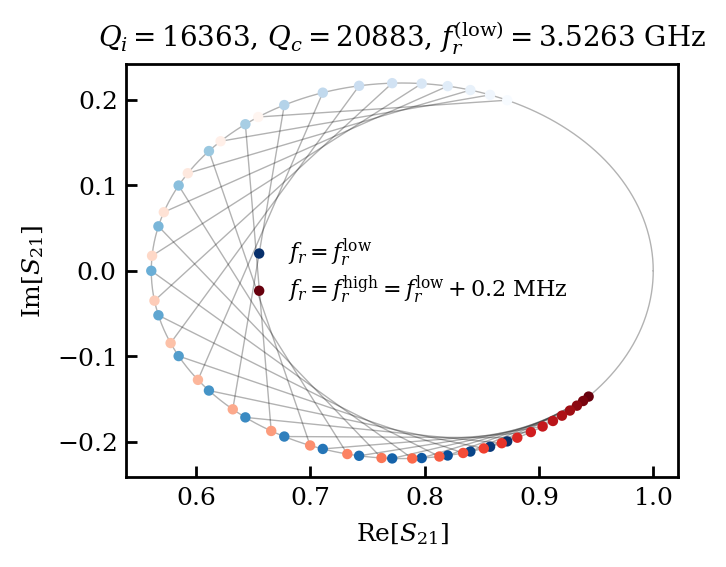

In [4]:
with plt.style.context(OCS._style_path):
    ring_low = S21(f=np.linspace(0, 9e10, 1000), fr=fr, Qi=Qi, Qc=Qc)
    fit_result_low = fit_circle_complex(ring_low)
    thetas = np.linspace(0, 2*np.pi, 1000)
    circle_x = fit_result_low['center'].real + fit_result_low['radius'] * np.cos(thetas)
    circle_y = fit_result_low['center'].imag + fit_result_low['radius'] * np.sin(thetas)
    plt.plot(circle_x, circle_y, lw=0.5, color="black", alpha=0.3)

    freqs = np.linspace(-0.3e6, 0.3e6, 27) + fr
    s21_low = S21(f=freqs, fr=fr, Qi=Qi, Qc=Qc)
    s21_high = S21(f=freqs, fr=fr+0.2e6, Qi=Qi, Qc=Qc)

    # Create colormaps for low and high frequency scatters
    cmap_blue = plt.cm.Blues
    cmap_red = plt.cm.Reds
    
    # Normalize frequency values for colormap
    norm_low = plt.Normalize(vmin=freqs.min(), vmax=freqs.max())
    norm_high = plt.Normalize(vmin=freqs.min(), 
                              vmax=freqs.max())
    

    plt.scatter(s21_low.real, s21_low.imag, c=freqs[::-1], 
                cmap=cmap_blue, norm=norm_low, s=30, zorder=10, 
                label=r"$f_r=f_r^\mathrm{low}$")
    plt.scatter(s21_high.real, s21_high.imag, c=freqs[::-1], 
                cmap=cmap_red, norm=norm_high, s=30, zorder=10,
                label=r"$f_r=f_r^\mathrm{high}=f_r^\mathrm{low} + 0.2~$MHz")
    for i in range(len(s21_high.imag)):
        plt.plot([s21_low.real[i], s21_high.real[i]], [s21_low.imag[i], s21_high.imag[i]], lw=0.5, color="black", alpha=0.3)

    plt.xlabel(r"Re[$S_{21}$]")
    plt.ylabel(r"Im[$S_{21}$]")
    plt.legend(loc="best")
    plt.title(r"$Q_i=$"+str(int(Qi))+", $Q_c=$"+str(int(Qc))+r", $f_r^\mathrm{(low)}=$"+str(fr/1e9)+" GHz")
    plt.show()

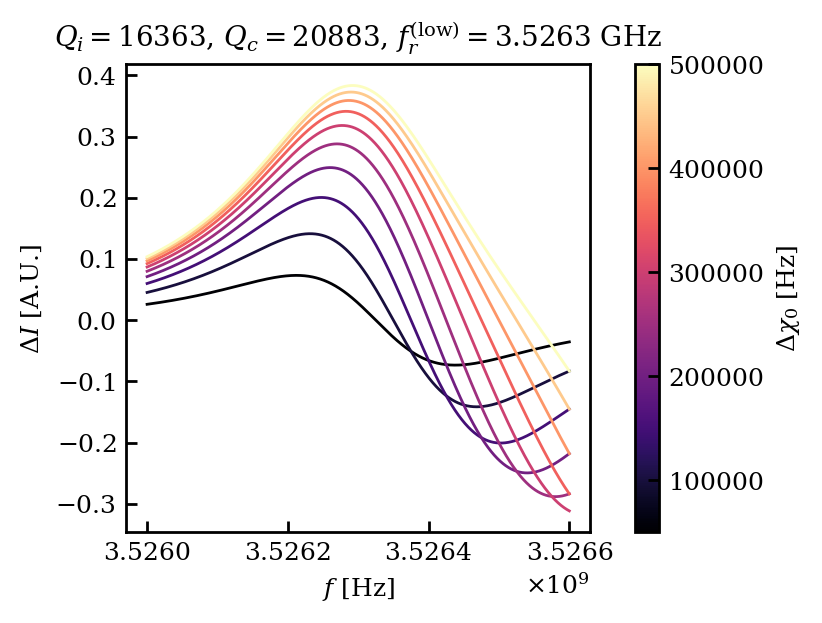

In [5]:

freqs = np.linspace(-3e5, 3e5, 2000) + fr
delta_chi_0s = np.linspace(0, 0.5e6, 11)[1:]

with plt.style.context(OCS._style_path):
    plt.figure(figsize=(4, 3))
    # Create colormap normalization for delta_chi_0 values
    cmap = plt.cm.magma
    norm = plt.Normalize(
        vmin=delta_chi_0s.min(), 
        vmax=delta_chi_0s.max()
    )
    
    for delta_chi_0 in delta_chi_0s:
        s21_low = S21(f=freqs, fr=fr, Qi=Qi, Qc=Qc)
        s21_high = S21(f=freqs, fr=fr+delta_chi_0, Qi=Qi, Qc=Qc)
        displacement = s21_high - s21_low
        color = cmap(norm(delta_chi_0))
        plt.plot(freqs, displacement.real, color=color)
    
    plt.xlabel(r"$f$ [Hz]")
    plt.ylabel(r"$\Delta I$ [A.U.]")
    plt.title(
        r"$Q_i=$"+str(int(Qi))+", $Q_c=$"+str(int(Qc))+", $f_r^\mathrm{(low)}=$"+str(fr/1e9)+" GHz"
    )
    
    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=plt.gca())
    cbar.set_label(r"$\Delta\chi_0$ [Hz]")


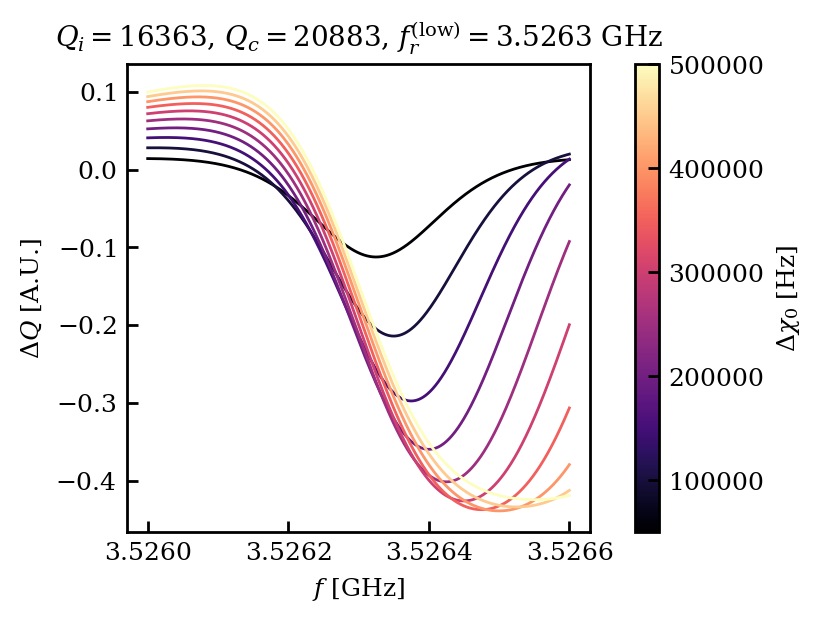

In [6]:
with plt.style.context(OCS._style_path):
    plt.figure(figsize=(4, 3))
    # Create colormap normalization for delta_chi_0 values
    cmap = plt.cm.magma
    norm = plt.Normalize(
        vmin=delta_chi_0s.min(), 
        vmax=delta_chi_0s.max()
    )
    
    for delta_chi_0 in delta_chi_0s:
        s21_low = S21(f=freqs, fr=fr, Qi=Qi, Qc=Qc)
        s21_high = S21(f=freqs, fr=fr+delta_chi_0, Qi=Qi, Qc=Qc)
        displacement = s21_high - s21_low
        color = cmap(norm(delta_chi_0))
        plt.plot(freqs/1e9, displacement.imag, color=color)
    
    plt.xlabel(r"$f$ [GHz]")
    plt.ylabel(r"$\Delta Q$ [A.U.]")
    plt.title(
        r"$Q_i=$"+str(int(Qi))+", $Q_c=$"+str(int(Qc))+", $f_r^\mathrm{(low)}=$"+str(fr/1e9)+" GHz"
    )
    
    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=plt.gca())
    cbar.set_label(r"$\Delta\chi_0$ [Hz]")


Let's extract the distance in I between the two peaks.

In [ ]:
from tqdm import tqdm
freqs = np.linspace(-3e7, 3e7, 60_000_000+1) + fr # Overkilled...
delta_chi_0s = np.linspace(0, 0.5e6, 201)

delta_freqs = []
for delta_chi_0 in tqdm(delta_chi_0s):
    s21_low = S21(f=freqs, fr=fr, Qi=Qi, Qc=Qc)
    s21_high = S21(f=freqs, fr=fr+delta_chi_0, Qi=Qi, Qc=Qc)
    displacement = s21_high - s21_low
    displacement_i = displacement.real
    freq_min = freqs[np.argmin(displacement_i)]
    freq_max = freqs[np.argmax(displacement_i)]
    delta_freq = np.abs(freq_max - freq_min)
    delta_freqs.append(delta_freq)

delta_freqs = np.array(delta_freqs)


 44%|████▍     | 89/201 [02:43<03:01,  1.62s/it]

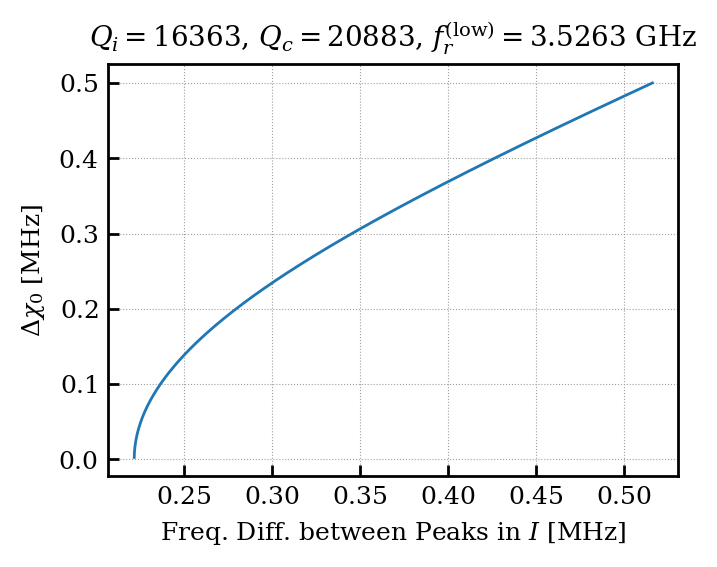

In [ ]:
with plt.style.context(OCS._style_path):
    plt.plot(delta_freqs[1:]/1e6, delta_chi_0s[1:]/1e6)
    plt.ylabel(r"$\Delta\chi_0$ [MHz]")
    plt.xlabel(r"Freq. Diff. between Peaks in $I$ [MHz]")
    plt.title(r"$Q_i=$"+str(int(Qi))+", $Q_c=$"+str(int(Qc))+", $f_r^\mathrm{(low)}=$"+str(fr/1e9)+" GHz")
    plt.grid()
    plt.show()

Why doesn't it go to 0 as $\Delta \chi_0$ approaches 0? Better understood analytically. It seems matheamtically nontrivial...

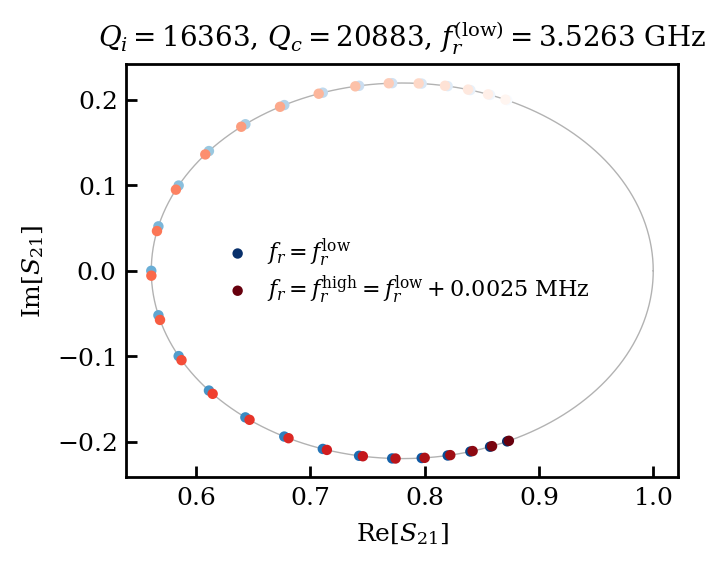

In [ ]:
with plt.style.context(OCS._style_path):
    ring_low = S21(f=np.linspace(0, 9e10, 1000), fr=fr, Qi=Qi, Qc=Qc)
    fit_result_low = fit_circle_complex(ring_low)
    thetas = np.linspace(0, 2*np.pi, 1000)
    circle_x = fit_result_low['center'].real + fit_result_low['radius'] * np.cos(thetas)
    circle_y = fit_result_low['center'].imag + fit_result_low['radius'] * np.sin(thetas)
    plt.plot(circle_x, circle_y, lw=0.5, color="black", alpha=0.3)

    freqs = np.linspace(-0.3e6, 0.3e6, 27) + fr
    s21_low = S21(f=freqs, fr=fr, Qi=Qi, Qc=Qc)
    s21_high = S21(f=freqs, fr=fr+delta_chi_0s[1], Qi=Qi, Qc=Qc)

    # Create colormaps for low and high frequency scatters
    cmap_blue = plt.cm.Blues
    cmap_red = plt.cm.Reds
    
    # Normalize frequency values for colormap
    norm_low = plt.Normalize(vmin=freqs.min(), vmax=freqs.max())
    norm_high = plt.Normalize(vmin=freqs.min(), 
                              vmax=freqs.max())
    

    plt.scatter(s21_low.real, s21_low.imag, c=freqs[::-1], 
                cmap=cmap_blue, norm=norm_low, s=30, zorder=10, 
                label=r"$f_r=f_r^\mathrm{low}$")
    plt.scatter(s21_high.real, s21_high.imag, c=freqs[::-1], 
                cmap=cmap_red, norm=norm_high, s=30, zorder=10,
                label=fr"$f_r=f_r^\mathrm{{high}}=f_r^\mathrm{{low}} + {delta_chi_0s[1]/1e6}~$MHz")
    for i in range(len(s21_high.imag)):
        plt.plot([s21_low.real[i], s21_high.real[i]], [s21_low.imag[i], s21_high.imag[i]], lw=0.5, color="black", alpha=0.3)

    plt.xlabel(r"Re[$S_{21}$]")
    plt.ylabel(r"Im[$S_{21}$]")
    plt.legend(loc="best")
    plt.title(r"$Q_i=$"+str(int(Qi))+", $Q_c=$"+str(int(Qc))+r", $f_r^\mathrm{(low)}=$"+str(fr/1e9)+" GHz")
    plt.show()

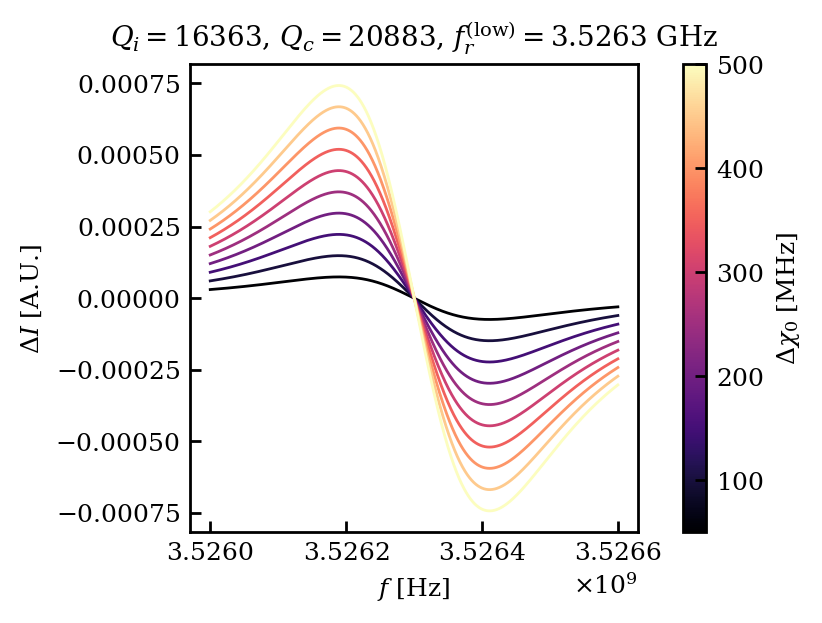

In [ ]:

freqs = np.linspace(-3e5, 3e5, 2000) + fr
delta_chi_0s = np.linspace(0, 0.5e6, 11)[1:]

with plt.style.context(OCS._style_path):
    plt.figure(figsize=(4, 3))
    # Create colormap normalization for delta_chi_0 values
    cmap = plt.cm.magma
    norm = plt.Normalize(
        vmin=delta_chi_0s.min(), 
        vmax=delta_chi_0s.max()
    )
    
    for delta_chi_0 in delta_chi_0s:
        s21_low = S21(f=freqs, fr=fr, Qi=Qi, Qc=Qc)
        s21_high = S21(f=freqs, fr=fr+delta_chi_0, Qi=Qi, Qc=Qc)
        displacement = s21_high - s21_low
        color = cmap(norm(delta_chi_0))
        plt.plot(freqs, displacement.real, color=color)
    
    plt.xlabel(r"$f$ [Hz]")
    plt.ylabel(r"$\Delta I$ [A.U.]")
    plt.title(
        r"$Q_i=$"+str(int(Qi))+", $Q_c=$"+str(int(Qc))+", $f_r^\mathrm{(low)}=$"+str(fr/1e9)+" GHz"
    )
    
    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=plt.gca())
    cbar.set_label(r"$\Delta\chi_0$ [Hz]")


Indeed seems mathematically nontrivial...

I asked Gemeni3 to do the tedious math to derive the analytical expression, and surprisingly it is independent of $Q_c$!

$$
\Delta f = \sqrt{ \frac{1}{3}} \frac{f_r}{Q_r} \sqrt{ \left( \frac{Q_r \Delta \chi_0}{f_r} \right)^2 - 1 + 2 \sqrt{ \left( \frac{Q_r \Delta \chi_0}{f_r} \right)^4 + \left( \frac{Q_r \Delta \chi_0}{f_r} \right)^2 + 1 } }
$$

At small $\Delta \chi_0$ limit $Q_r \Delta \chi_0/f_r \rightarrow 0$ , it becomes

$$
\Delta f \rightarrow \frac{Q_r \Delta \chi_0}{f_r}
$$

This is truly remarkable! 

In [ ]:
def calculate_delta_f(delta_chi_0, f_r, Q_r):
    """
    Calculate the frequency shift Delta f using the given equation.
    
    Parameters
    ----------
    delta_chi_0 : float or array-like
        The primary susceptibility parameter (Delta chi_0)
    f_r : float
        Resonance frequency
    Q_r : float
        Quality factor
    
    Returns
    -------
    delta_f : float or array
        The frequency shift Delta f
    
    Notes
    -----
    Equation:
    Delta f = sqrt(1/3) * (f_r/Q_r) * 
              sqrt((Q_r*Delta_chi_0/f_r)^2 - 1 + 
                   2*sqrt((Q_r*Delta_chi_0/f_r)^4 + 
                          (Q_r*Delta_chi_0/f_r)^2 + 1))
    """
    # Define the normalized parameter
    x = Q_r * delta_chi_0 / f_r
    
    # Calculate the inner square root term
    inner_sqrt = np.sqrt(x**4 + x**2 + 1)
    
    # Calculate the outer square root term
    outer_sqrt = np.sqrt(x**2 - 1 + 2 * inner_sqrt)
    
    # Calculate Delta f
    delta_f = np.sqrt(1/3) * (f_r / Q_r) * outer_sqrt
    
    return delta_f

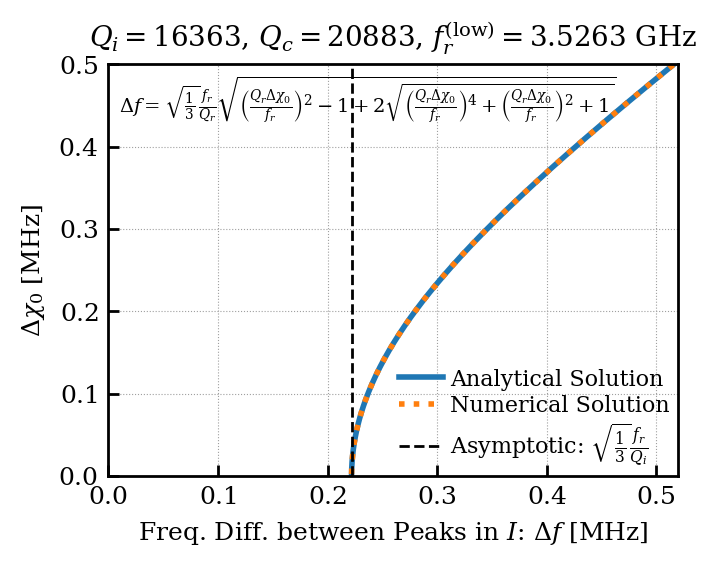

In [ ]:
delta_fs = calculate_delta_f(delta_chi_0=delta_chi_0s[1:], f_r=fr, Q_r=1/(1/Qi+1/Qc))

with plt.style.context(OCS._style_path): 
    plt.plot(delta_fs/1e6, delta_chi_0s[1:]/1e6, lw=2, label="Analytical Solution")
    plt.plot(delta_freqs[1:]/1e6, delta_chi_0s[1:]/1e6, ls=":",lw=2, label="Numerical Solution")
    plt.axvline(np.sqrt(1/3)*fr/(1/(1/Qi+1/Qc))/1e6, color="black", ls="--", label=r"Asymptotic: $\sqrt{\frac{1}{3}} \frac{f_r}{Q_i}$", lw=1)
    plt.text(0.01, 0.44, r"$\Delta f=\sqrt{\frac{1}{3}} \frac{f_r}{Q_r} \sqrt{\left(\frac{Q_r \Delta \chi_0}{f_r}\right)^2-1+2 \sqrt{\left(\frac{Q_r \Delta \chi_0}{f_r}\right)^4+\left(\frac{Q_r \Delta \chi_0}{f_r}\right)^2+1}}$", fontsize=7)
    plt.ylabel(r"$\Delta\chi_0$ [MHz]")
    plt.xlabel(r"Freq. Diff. between Peaks in $I$: $\Delta f$ [MHz]")
    plt.title(r"$Q_i=$"+str(int(Qi))+", $Q_c=$"+str(int(Qc))+", $f_r^\mathrm{(low)}=$"+str(fr/1e9)+" GHz")
    plt.ylim(0)
    plt.xlim(0, 0.52)
    plt.ylim(0, 0.5)
    plt.legend(loc="best")
    plt.grid()
    plt.show()

Note that, in reality, due to the noises you will not be able to identify "peaks" from timestream std data when $\Delta \chi_0$ is so small. In this case, it will be indistinguishable from dead qubit.

# Read $\xi$ from $\Delta \chi_0$

For fair comparison, let's just assume $n_g=0.5$ where we usually have the maximum $\Delta \chi_0$.

In [ ]:
from ocs_transmon import OCS

E_C_REFERENCE_Hz = 1.0e9
COUPLING_G_REFERENCE_Hz = 100e6

xis = np.linspace(1, 20, 500)
delta_chi_0s = []
for xi in xis:
    ocs = OCS(e_j_hz=E_C_REFERENCE_Hz*xi, e_c_hz=E_C_REFERENCE_Hz)
    delta_chi_0 = ocs.compute_delta_chi_0(
        readout_freqs=fr,
        offset_charges=0.5,
        coupling_g_hz=COUPLING_G_REFERENCE_Hz,
        num_levels=20
    )
    delta_chi_0s.append(np.abs(delta_chi_0[0,0]))
delta_chi_0s = np.array(delta_chi_0s)
    

/var/folders/b4/tkxxqysd1pd6vc7155459qcm0000gn/T/ipykernel_57992/2190284591.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('magma')


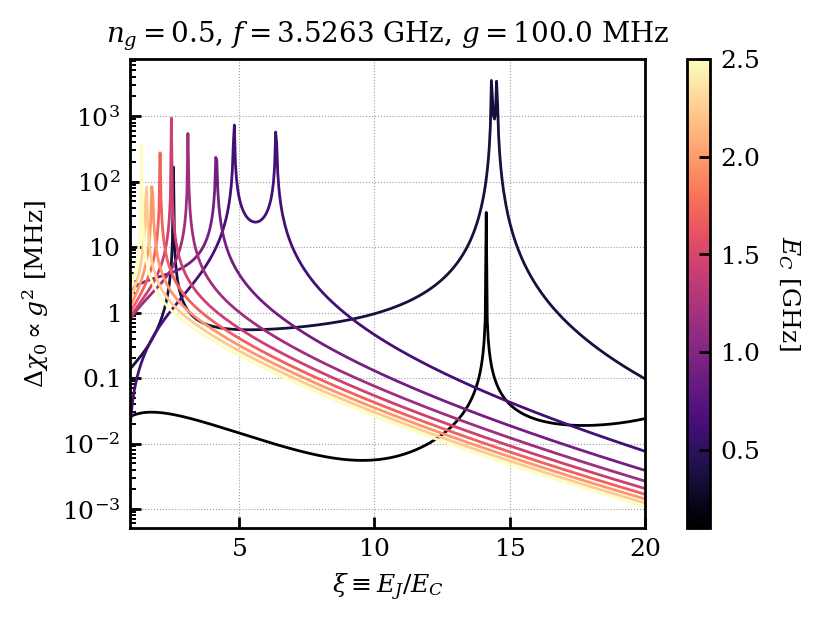

In [ ]:
with plt.style.context(OCS._style_path): 
    fig, ax = plt.subplots(figsize=(4, 3))
    xis = np.linspace(1, 20, 500)
    ec_values = np.linspace(0.1e9, 2.5e9, 10)
    cmap = cm.get_cmap('magma')
    norm = plt.Normalize(vmin=ec_values[0]/1e9, 
                         vmax=ec_values[-1]/1e9)
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    
    for idx, ec in enumerate(ec_values):
        delta_chi_0s = []
        for xi in xis:
            ocs = OCS(e_j_hz=ec*xi, e_c_hz=ec)
            delta_chi_0 = ocs.compute_delta_chi_0(
                readout_freqs=fr,
                offset_charges=0.5,
                coupling_g_hz=COUPLING_G_REFERENCE_Hz,
                num_levels=20
            )
            delta_chi_0s.append(np.abs(delta_chi_0[0,0]))
        delta_chi_0s = np.array(delta_chi_0s)
        color = cmap(norm(ec/1e9))
        ax.plot(xis, delta_chi_0s/1e6, color=color)
    
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label(r'$E_C$ [GHz]', rotation=270, labelpad=15)
    
    ax.set_xlabel(r"$\xi\equiv E_J/E_C$")
    ax.set_ylabel(r"$\Delta \chi_0 \propto g^2$ [MHz]")
    ax.set_title(r"$n_g=0.5$, $f=$"+str(fr/1e9)+" GHz" + 
                 ", $g=$"+str(COUPLING_G_REFERENCE_Hz/1e6)+" MHz")
    ax.set_yscale("log")
    ax.set_xlim(1, 20)
    ax.grid()
    plt.show()
